# Extract depth distribution from each image

### 1. Read depth images and assign them an id corresponding to the visibility location:

In [1]:
import os
import numpy as np
import pandas as pd
import glob

from PIL import Image

from tqdm import tqdm
tqdm.pandas()



# vis_df = pd.read_csv("./rodrigo_data/rodrigo_data_012224/pos2185-4-visibility-70/visibility.csv")
vis_df = pd.read_csv("./rodrigo_data/NY_extended/visibility.csv")
print(f"Found {vis_df.shape[0]} positions for visibility analysis")

#depth images
images_list = glob.glob("./rodrigo_data/NY_extended/depth/*.png")
print(f"Found {len(images_list)} positions for depth analysis")


#data frame with depth image paths and same id as the visibility image names
depth_images_df = pd.DataFrame(images_list, columns=["image_path"])
depth_images_df["image_name"] = depth_images_df["image_path"].apply(lambda n: \
            n.split("/")[-1][:-4].replace("depth", "visibility"))
#sort the image paths based on their visibility image name:
depth_images_df = depth_images_df.sort_values("image_name").set_index("image_name")

print(f"\nExample: \n\t    image name: {depth_images_df.head(1).index.values[0]}\
        \n\tand image path: {depth_images_df.iloc[0].values[0]}", )


Found 78696 positions for visibility analysis
Found 34220 positions for depth analysis

Example: 
	    image name: pos0-0-visibility-120        
	and image path: ./rodrigo_data/NY_extended/depth/pos0-0-depth-120.png


### 2. Read a depth image and extract the depth histogram.

Return the depth histogram and the mode of the histogram (aside of the sky pixels)

In [2]:

def get_depth_distribution_from_image(image_path):
    """Return depth distrbution and mode (bin where depths are clustered) of the depth.
    depth_percentage - list of percentages for the depth bins 
        - sums up to 1.
        - normalized by the number of pixels in the image.
        - sky pixels are considered in the furthes away bin;
    depth_mode - which bin is the mode of the depth distribution aside of the sky pixels.
    returns: depth_percentages, depth_mode
    """
    pil_img     = Image.open(image_path)
    np_img      = np.array(pil_img)
    num_pixels  = np.prod(np_img.shape[:2])

    #gray pixels have all channel values equal:
    gray_pixels = np_img[(np_img[:,:,0] == np_img[:,:,1]) & (np_img[:,:,1] == np_img[:,:,2])]

    #total num of pixels 
    num_sky_pixels = num_pixels - gray_pixels.shape[0]

    #create np histogram from gray_pixels with 10 bins
    bins = np.arange(0, 270, 26) #ten equal sized bins.
    #gray_pixels_histogram.sum() should be equal to gray_pixels.shape[0]
    gray_pixels_histogram = np.histogram(gray_pixels[:,0], bins=bins)[0]
    #depth mode computed before adding the sky pixels.
    depth_mode = np.argmax(gray_pixels_histogram) 
    
    #add sky pixels as the furthest away 
    gray_pixels_histogram[-1] += num_sky_pixels
    depth_percentages = gray_pixels_histogram / num_pixels
    
    return depth_percentages, depth_mode

#depth distrubutions and modes for each image:
depth_images_df["depth_percentages"] = depth_images_df["image_path"].progress_apply(get_depth_distribution_from_image)
#Assign depth mode to separate column and keep only the distribution in the depth_percentages column:
depth_images_df["depth_mode"]        = depth_images_df["depth_percentages"].apply(lambda d: d[1])
depth_images_df["depth_percentages"] = depth_images_df["depth_percentages"].apply(lambda d: d[0])

get_depth_distribution_from_image(depth_images_df.iloc[6]["image_path"])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34220/34220 [04:52<00:00, 116.91it/s]


(array([0.        , 0.        , 0.        , 0.08613004, 0.21498747,
        0.12415702, 0.06348422, 0.03563043, 0.00677477, 0.46883606]),
 4)

### 3. add depth distribution to the vis_df dataframe and save it as a training csv 

# To Dos:

- ok - Documentation of the implemented steps
- Export new data frame as csv
- plot locations in depth df vs locations in vis_df to make sure they are distributed around the entire scene.
- run training epochs for new dataframe.
    - modify `train_model_on_data`  to consider `f_xyz_2`
    
    
    - only __exclude 7 miscelaneous__ (street furniture) sli to be [0,1,2,3,4,5,6] out of [' building', ' water', ' road ', ' sidewalk', ' surface', ' tree', ' sky', ' miscelaneous']
- replace new model in server.py.

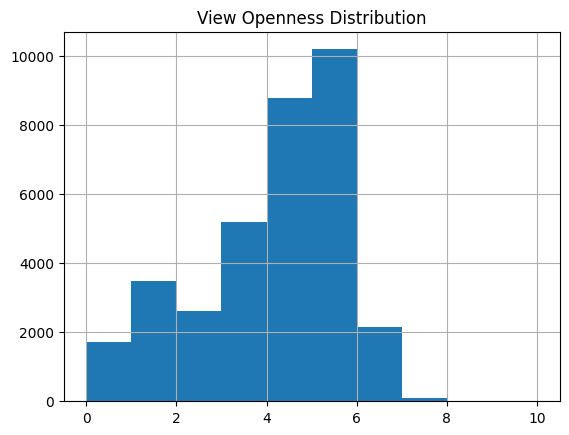

In [3]:
import matplotlib.pyplot as plt

depth_images_df.hist("depth_mode", bins=range(11))
plt.title("View Openness Distribution")
plt.show()

In [10]:
vis_depth_df               = vis_df[vis_df["image_name"].isin(depth_images_df.index)].copy()

#transform percentages into tanh logits \in -1, 1
vis_depth_df["f_xyz"]    = vis_depth_df["f_xyz"].apply(eval)
vis_depth_df["f_xyz_2"]    = vis_depth_df.apply(lambda r: (depth_images_df["depth_percentages"].loc[r["image_name"]]-.5)*2, axis=1)

# vis_depth_df["f_xyz_2"]    = vis_depth_df.apply(lambda r: np.hstack([eval(r["f_xyz"]), depth_images_df["depth_percentages"].loc[r["image_name"]]]), axis=1)
# vis_depth_df["depth_mode"] = vis_depth_df.apply(lambda r: depth_images_df["depth_mode"].loc[r["image_name"]], axis=1)
vis_depth_df

vis_depth_df.to_json("locations_extended.json", orient="records", indent=4)

In [17]:
pd.read_json("locations_extended.json")["f_xyz"].values[0],\
pd.read_json("locations_extended.json")["f_xyz_2"].values[0]


([2178, 1547, 0, 212, 1588, 70883, 192953, 0],
 [-1.0,
  -0.7098280489000001,
  -0.7443153732000001,
  -1.0,
  -0.9998234588,
  -0.9954717181,
  -0.9937416143000001,
  -0.9942800650000001,
  -0.995454064,
  0.4329143422])

In [21]:
".json" in "locations_extended.json"

True

# Analyze Building data from model files

# Initial Analysis of depth information in images.

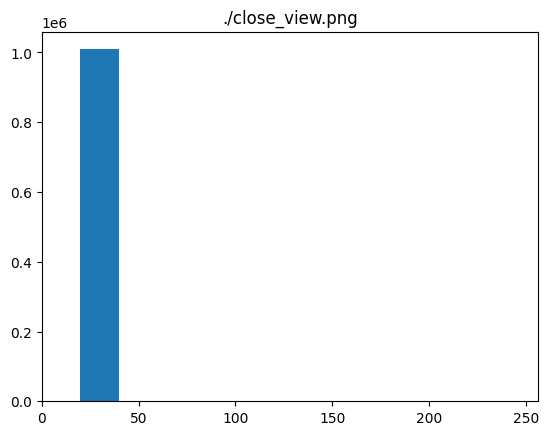

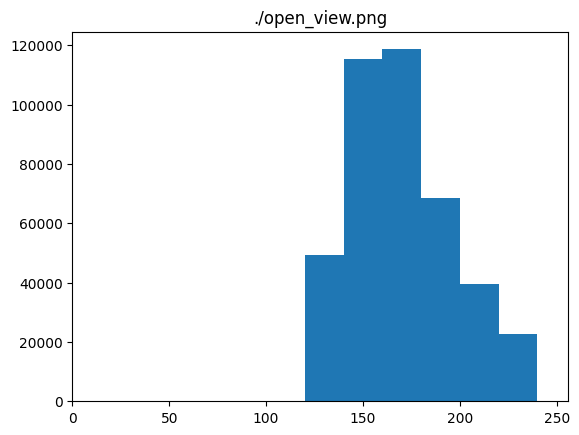

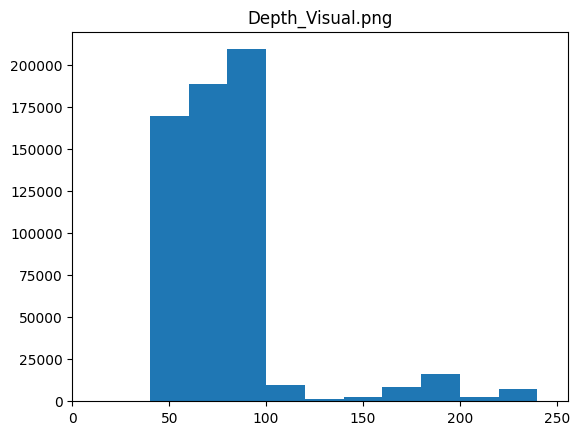

In [23]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


for img_name in ["./close_view.png", "./open_view.png", "Depth_Visual.png"]:
    
    pil_img     = Image.open(img_name)
    np_img      = np.array(pil_img)
    gray_pixels = np_img[(np_img[:,:,0] == np_img[:,:,1]) & (np_img[:,:,1] == np_img[:,:,2])]

    plt.hist(gray_pixels[:,0], bins=range(0, 260, 20))
    plt.title(img_name)
    plt.xlim(0,256)
    plt.show()